In [1]:
import random, ast
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms
import os 

from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

See info and class indices at
https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/


In [2]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Classification function for LIME

Define the classification function LIME needs. 
Input: numpy array of images where each image is ndarray of shape (channel, height, width).
Output: numpy array of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [3]:
def prediction_function(images):
    model.eval()
    images_transformed = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    logits = model(images_transformed)
    preds = logits.softmax(dim=1)
    return preds.detach().cpu().numpy()

# Image loading and preprocessing

In [4]:
with open("imagenet1000_clsidx_to_labels.txt", "r", encoding="utf-8") as f:
    text = f.read()
labels_dict = ast.literal_eval(text) 

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

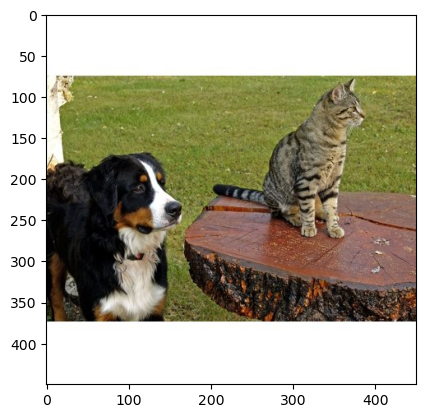

In [6]:
img = get_image('cat_dog.png')
plt.imshow(img)

# LIME

In [7]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         prediction_function, # classification function
                                         top_labels=5, # produce explanations for this many of the top predictions
                                         num_samples=1000) # size of the neighborhood to learn the linear model

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

['Appenzeller', 'Bernese mountain dog', 'EntleBucher', 'Greater Swiss Mountain dog', 'tabby, tabby cat']


Overlay the mask on from LIME on the image to see which areas encourage the top prediction

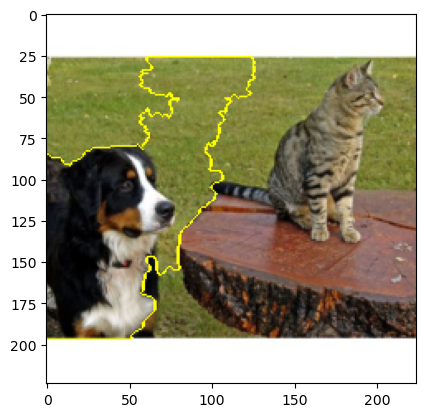

In [9]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[1],
                                             positive_only=True, # only include superpixels that contribute positively to the prediction
                                             num_features=6, # number of superpixels to include in explanation
                                             hide_rest=False # make the non-explanation part of the return image gray
                                            )
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)

Display areas also areas that contribute against the top prediction.

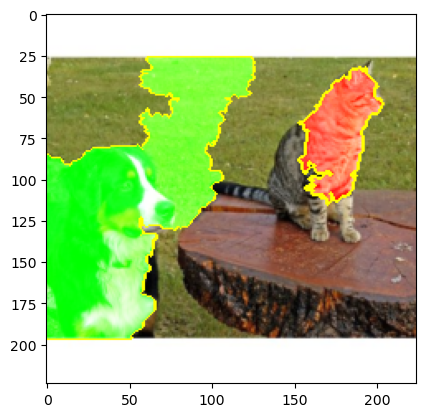

In [10]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[1],
                                                         positive_only=False,
                                                         negative_only=False,
                                                         num_features=7,
                                                         hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)

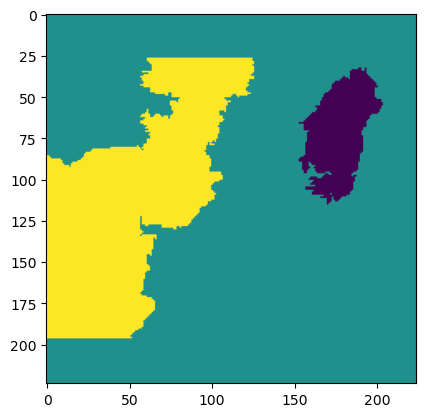

In [11]:
plt.imshow(mask)

In [12]:
np.unique(np.array(mask))

array([-1,  0,  1])

## New instance

  0%|          | 0/1000 [00:00<?, ?it/s]

['tench, Tinca tinca', 'bolete', 'armadillo', 'isopod', 'mud turtle']


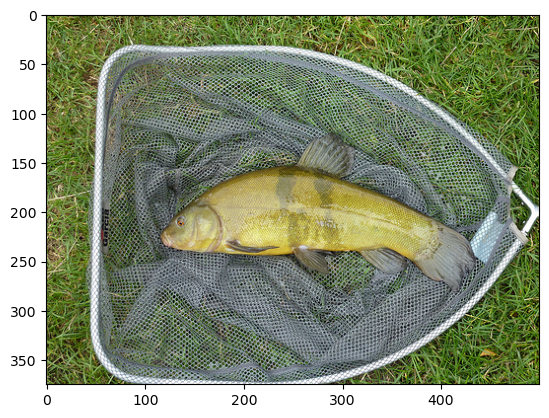

In [13]:
img = get_image('fish.jpg')
plt.imshow(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), prediction_function, top_labels=5, num_samples=1000)

top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

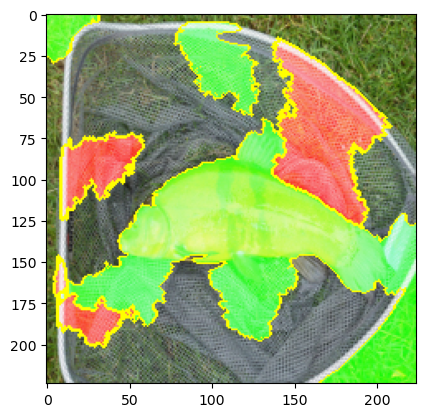

In [14]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)

  0%|          | 0/1000 [00:00<?, ?it/s]

['coral reef', 'scuba diver', 'rock beauty, Holocanthus tricolor', 'jellyfish', 'anemone fish']


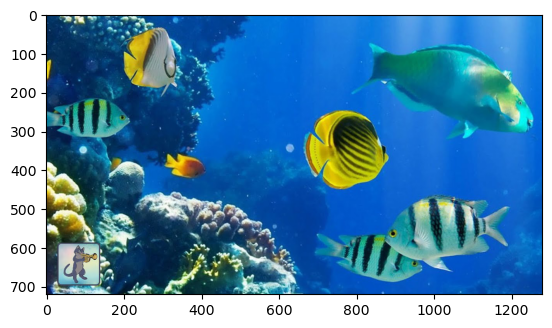

In [15]:
img = get_image('aquarium.jpg')
plt.imshow(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), prediction_function, top_labels=5, num_samples=1000)

top_classes = [labels_dict[_label] for _label in explanation.top_labels]
print(top_classes)

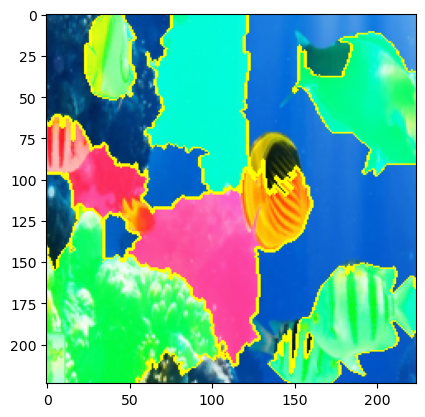

In [16]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundary = mark_boundaries(image/255.0, mask)
plt.imshow(img_boundary)